# Latent Dirichlet Allocation with taxi trips

This notebook will fit an LDA model to taxi trip data in order to classify different types of trips. 
It will also predict the probability that each type of trip will occur at at given daty and time. 

Steps: 
- prepare data (initial data cleaning and preparation done in the other notebook in QGIS.
- prepare the "dictionary" (define trips) and "corpora" (the set of trips in a city)
- hold out testing data
- fit model, tune parameters
- visualize results




TODO: timestamps got messed up when tried to update in Feb 2016. Have to use the new files with correct timestamps. 

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import logging
from gensim import corpora, models, similarities

# Prepare Data


Before this, I created a grid with 1000m cells, then used PostGIS to spatially join the trip origiin (o) and destination (d) with grid cell IDs. 

In [37]:
 # load csv files with trips already matched to o and d cells

filename= 'working_data/sf_trips.csv'
sf_data = pd.read_csv(filename, dtype={'taz_orig': str, 'taz_dest':str}, parse_dates= ['startdate','enddate'])
sf_data.head
# TODO: Somehow the dates got messed up in the update. Need to go back and store datetimes as strings. 

In [46]:
# Look at missing data. I think the taz's are missing because they were outside the TAZ boundaries. 
# TODO: Check if this is actually the case. 
print(len(sf_data[sf_data.taz_orig.isnull()]))
print(len(sf_data[sf_data.taz_dest.isnull()]))

# Drop NA's. Caution - a lot will be dropped. 
sf_data_dropped = sf_data.dropna(how='any')
len(sf_data_dropped)/len(sf_data)


(702032, 17)
    tripid      d_lat       d_lng  dist             enddate  endday  endhour  \
10      10  37.799390 -122.424988   2.1 2013-10-01 00:12:00       1        0   
11      11  37.764913 -122.423213   1.9 2013-10-01 00:16:00       1        0   
12      12  37.783487 -122.415695   0.9 2013-10-01 00:19:00       1        0   
13      13  37.791582 -122.420673  13.7 2013-10-01 00:17:00       1        0   
14      14  37.783755 -122.415928   1.0 2013-10-01 00:18:00       1        0   
15      15  37.781320 -122.432455   1.8 2013-10-01 00:20:00       1        0   
16      16  37.782773 -122.444800   3.1 2013-10-01 00:19:00       1        0   
17      17  37.789352 -122.412102   0.5 2013-10-01 00:21:00       1        0   
18      18  37.785207 -122.418130   0.6 2013-10-01 00:21:00       1        0   
19      19  37.760287 -122.419055   1.8 2013-10-01 00:18:00       1        0   

    month      o_lat       o_lng           startdate  startday  starthour  \
10     10  37.794930 -122.399

0.5411790345739226

In [13]:
# Read NYC data
filename= 'working_data/nyc_trips.csv'
nyc_data = pd.read_csv(filename,dtype={'taz_orig': str, 'taz_dest': str}, usecols = [0,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
print(len(nyc_data))
nyc_data.head()

1481756


,tripid,trip_time,dist,o_lng,o_lat,d_lng,d_lat,year,month,startday,starthour,endday,endhour,taz_orig,taz_dest
0,3059374,1084,4.60,-73.923874,40.770187,-73.952225,40.772835,2013,10,0,7,0,7,NaN,3606100013600
1,1480323,1118,11.20,-73.970627,40.754700,-73.865089,40.770554,2013,10,0,13,0,13,3606100009001,NaN
2,3914387,240,1.10,-74.009956,40.735149,-73.999443,40.743870,2013,10,1,22,1,22,3606100007500,3606100008700
3,13323926,420,0.75,-73.972542,40.764717,-73.971870,40.757217,2013,10,2,22,2,22,3606100011401,3606100010000
4,11665692,540,1.38,-73.962212,40.755596,-73.949509,40.772549,2013,10,3,10,3,10,3606100010601,3606100013600


In [39]:
# add date column so can group by date. 

def make_date_column(df):
    datelist = []
    for i, row in df.iterrows():
        date = row['startdate'].date()
        datelist.append(date)
    df['date'] = datelist
    return df

nyc_data = make_date_column(nyc_data)
sf_data = make_date_column(sf_data_dropped)
sf_data.head()
        

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,tripid,d_lat,d_lng,dist,enddate,endday,endhour,month,o_lat,o_lng,startdate,startday,starthour,trip_time,year,taz_orig,taz_dest,date
0,0,37.805305,-122.472953,5.0,2013-10-01 00:04:00,1,0,10,37.804945,-122.472388,2013-10-01 00:03:00,1,0,60,2013,0607500104176,0607500104176,2013-10-01
1,1,37.791295,-122.414613,0.8,2013-10-01 00:09:00,1,0,10,37.792920,-122.400507,2013-10-01 00:05:00,1,0,240,2013,0607500104293,0607500103919,2013-10-01
2,2,37.555052,-122.324047,7.5,2013-10-01 00:09:00,1,0,10,37.616057,-122.391168,2013-10-01 00:00:00,1,0,540,2013,0608100102169,0608100102066,2013-10-01
4,4,37.742243,-122.465177,1.9,2013-10-01 00:10:00,1,0,10,37.765732,-122.466452,2013-10-01 00:05:00,1,0,300,2013,0607500104167,0607500103992,2013-10-01
5,5,37.783253,-122.432853,1.7,2013-10-01 00:12:00,1,0,10,37.769750,-122.448700,2013-10-01 00:05:00,1,0,420,2013,0607500104418,0607500104402,2013-10-01


In [42]:
# how many days are there? 
print(len(sf_data.date.unique()))
# when do they start?
sf_data.startdate.min()

123


Timestamp('2012-10-01 00:00:00')

In [342]:
#nyc_data.to_hdf('taxi_nyc/nyc_data.all.h5','df')
#sf_data.to_hdf('taxi_sf/sf_data.all.h5','df')

/Users/lrayle/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2453: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->date,key->block3_values] [items->['date']]

  warnings.warn(ws, PerformanceWarning)


# Prepare Dictionary and Corpora

In [116]:
# make a document for each hour in entire list
# Gensim dictionary takes as input a list of arrays of strings

def make_docs_by_hour(df):
    doc_list = [] # there will be a doc for each hour observed in dataset
    doc_index = [] # just to keep track of the hours
    for date in df.date.unique():
        for hour in range(24):
            doc = [] # each doc is a list of od pairs
            for i, row in df[(df.date == date)& (df.starthour == hour)].iterrows():

                pair = str(row['o_grid'])+','+str(row['d_grid'])
                doc.append(pair)
            doc_list.append(doc)
            doc_index.append([date,hour])
            
    return doc_list, doc_index

sf_docs_temp, sf_ind_temp = make_docs_by_hour(sf_data)
nyc_docs_temp, nyc_ind = make_docs_by_hour(nyc_data)

df_nyc_ind = pd.DataFrame(nyc_ind, columns = ['date','hour'])
df_sf_ind = pd.DataFrame(sf_ind_temp, columns = ['date','hour'])

# the 'doc_id' column preserves the inex of the documents. E.g., the index of 
# the sf_docs_temp matches the doc_id in df_sf_ind
df_nyc_ind['doc_id'] = df_nyc_ind.index
df_sf_ind['doc_id'] = df_sf_ind.index
df_sf_ind.head()

# this is important because the dates are out of order and we'll later have to order them. 

In [ ]:
#for i, doc in enumerate(sf_docs_temp):
    #if len(doc)<10:
     #   print df_sf_ind.date[i]
# aha! for some reason the last day of each month is missing data. That's ok, I think, just don't try to plot it.

def make_tottrips_list(docs):
    tt_list = []
    for doc in docs: 
        tt_list.append(len(doc))
    return(tt_list)


df_nyc_ind['tot_trips'] = make_tottips_list(nyc_docs_temp)
df_nyc_ind['tot_trips'] = make_tottips_list(sf_docs_temp)

## Hold out test data

In [165]:

# hold out some documents for testing. 

# for NY, choose a few representative days Tues Oct 8, Wed Oct 16, Thu Oct 24 and Sat Oct 26
test_date_list = [datetime.date(2013, 10, 8), datetime.date(2013, 10, 16),datetime.date(2013, 10, 24),datetime.date(2013, 10, 26) ]
nyc_test_ids = df_nyc_ind[df_nyc_ind['date'].isin(test_date_list) ].index.values
nyc_train_ids = df_nyc_ind[~df_nyc_ind['date'].isin(test_date_list) ].index.values


# for SF, choose seven representative days Tues Oct 8, Wed Oct 16, Thu Oct 24 and Sat Oct 26
test_date_list = [datetime.date(2013, 10, 8), datetime.date(2013, 10, 16),datetime.date(2013, 10, 24),datetime.date(2013, 10, 26), datetime.date(2013, 8, 11), datetime.date(2013, 8, 12),datetime.date(2013, 8, 28) ]
sf_test_ids = df_sf_ind[df_sf_ind['date'].isin(test_date_list) ].index.values
sf_train_ids = df_sf_ind[~df_sf_ind['date'].isin(test_date_list) ].index.values

nyc_docs_test = [nyc_docs_temp[i] for i in nyc_test_ids]
nyc_docs_train = [nyc_docs_temp[i] for i in nyc_train_ids]

sf_docs_test = [sf_docs_temp[i] for i in sf_test_ids]
sf_docs_train = [sf_docs_temp[i] for i in sf_train_ids]


In [ ]:
# BEFORE TUNING PARAMETERS: create dictionary using the training dataset

nyc_dict = corpora.Dictionary(nyc_docs_train)
sf_dict = corpora.Dictionary(sf_docs_train)


# filter out paris that only appear in one document
sf_dict.filter_extremes(no_below=1)
nyc_dict.filter_extremes(no_below=1)

#print(sf_dict)
#print(nyc_dict)

# save for future use. NOTE: '1000' refers to the fact that this uses the 1000m grid. 
nyc_dict.save('working_data/nyc_grid1000.dict')
sf_dict.save('working_data/sf_grid1000.dict')

In [ ]:
# convert training data to a corpus
sf_corpus = [sf_dict.doc2bow(doc) for doc in sf_docs_train]
nyc_corpus = [nyc_dict.doc2bow(doc) for doc in nyc_docs_train]

# save corpus
corpora.MmCorpus.serialize('working_data/sf_corpus_grid1000.mm', sf_corpus)
corpora.MmCorpus.serialize('working_data/nyc_corpus_grid1000.mm', nyc_corpus)

# also make the test corpus
sf_corpus_test = [sf_dict.doc2bow(doc) for doc in sf_docs_test]
nyc_corpus_test = [nyc_dict.doc2bow(doc) for doc in nyc_docs_test]

# save corpus
corpora.MmCorpus.serialize('working_data/sf_corpus_grid1000_test.mm', sf_corpus_test)
corpora.MmCorpus.serialize('working_data/nyc_corpus_grid1000_test.mm', nyc_corpus_test)

In [348]:
# AFTER TUNING PARAMETERS: make dictionary out of entire dataset. 

sf_docs = sf_docs_temp
nyc_docs = nyc_docs_temp

nyc_dict = corpora.Dictionary(nyc_docs)
sf_dict = corpora.Dictionary(sf_docs)


# filter out paris that only appear in one document
sf_dict.filter_extremes(no_below=1)
nyc_dict.filter_extremes(no_below=1)

print(sf_dict)
print(nyc_dict)

# save for future use. NOTE: '1000' refers to the fact that this uses the 1000m grid. 
nyc_dict.save('working_data/nyc_grid1000.dict')
sf_dict.save('working_data/sf_grid1000.dict')

Dictionary(19826 unique tokens: [u'14978,14980', u'17751,21782', u'15432,15132', u'15432,15133', u'14975,15596']...)
Dictionary(31765 unique tokens: [u'1054,1424', u'1054,1429', u'961,1355', u'961,1354', u'542,1448']...)
Dictionary(19805 unique tokens: [u'14978,14980', u'15128,15286', u'15432,15131', u'15432,15132', u'15432,15133']...)
Dictionary(31229 unique tokens: [u'1054,1424', u'1054,1429', u'961,1355', u'961,1354', u'542,1448']...)


In [349]:
# and convert training data to a corpus
sf_corpus = [sf_dict.doc2bow(doc) for doc in sf_docs]
nyc_corpus = [nyc_dict.doc2bow(doc) for doc in nyc_docs]

# temporarily save corpus if need to stop in middle.
corpora.MmCorpus.serialize('working_data/sf_corpus_grid1000.mm', sf_corpus)
corpora.MmCorpus.serialize('working_data/nyc_corpus_grid1000.mm', nyc_corpus)



In [55]:
# use this to load dictionaries and corpora later. 
#sf_corpus = corpora.MmCorpus('working_data/sf_corpus_grid1000.mm')
#nyc_corpus = corpora.MmCorpus('working_data/nyc_corpus_grid1000.mm')


#sf_dict = corpora.Dictionary.load('working_data/sf_grid1000.dict')
#nyc_dict = corpora.Dictionary.load('working_data/nyc_grid1000.dict')



# Train LDA model

In [350]:
# LDA

def generate_topics(corpus, dictionary, k, alpha):
    lda = models.ldamodel.LdaModel(corpus, id2word=dictionary,alpha = alpha, num_topics=k, passes = 10, iterations = 1000)
    return lda


k=5
print 'processing ny'
nyc_lda = generate_topics(nyc_corpus, nyc_dict, k, .5)
sf_lda = generate_topics(sf_corpus, sf_dict, k, .25)
print 'done with sf'

processing ny
done with sf


In [223]:
# this will minimize perplexity

def minimize_perplexity(corpus, test, dictionary,k_range, a):
    perplexities = []
    for k in k_range:
        lda  = generate_topics(corpus, dictionary, k, a)
        per = lda.log_perplexity(test)
        print k, per
        row = [k, per]
        perplexities.append(row)
    return np.array(perplexities)

In [226]:
#alpha = 'auto'
k_range = [3,4,5,6,7]
#alpha_range = [.001, .01, .05, .1, .25, .3, .5]
sf_perplexities = minimize_perplexity(sf_corpus, sf_corpus_test, sf_dict,k_range, .5)

3 -9.86662175517


KeyboardInterrupt: 

In [ ]:
# That didn't work, try different parameters
k_range = [3,4,5,6,7]
alpha_range = [.2, .7]
nyc_perplexities_a = minimize_perplexity(nyc_corpus, nyc_corpus_test, nyc_dict,k_range, .25)

In [221]:
k_range = [3,4,5,6,7]
k = 5
print 'sf'
sf_perplexitiesk5_2 = minimize_perplexity(sf_corpus, sf_corpus_test, sf_dict,k, alpha_range)
print 'ny'
nyc_perplexities_k5_2 = minimize_perplexity(nyc_corpus, nyc_corpus_test, nyc_dict,k, [.2])

0.2 -9.92272747814
0.7 -9.80501621986
k=5
sf
0.2 -9.95202100098
0.7 -10.2895477958
ny
0.2 -9.82568539961


In [155]:
alpha = 'auto'
k = 3 # number of topics 
sf_lda = models.ldamodel.LdaModel(sf_corpus, id2word=sf_dict, num_topics=k, alpha = alpha, iterations = 200)


# Visualize results

In [381]:
# make csv table to visualize in QGIS. 

# inputs are LDA model instance and k= number of topics and n=number of pairs to show
def get_topic_probs(model,k, n):
    pairs = []
    for t in range(k):
        words = model.show_topic(t, n)
        for p,w in words:
            orig = str(w.split(',')[0]).rstrip('.0')
            dest = str(w.split(',')[1]).rstrip('.0')
            pair = '(' + orig + ',' + dest+ ')'
            prob = float(p)
            topic = int(t)
            row = [orig, dest, pair, prob, topic]
            pairs.append(row)
    df = pd.DataFrame(pairs, columns=['orig','dest','pair','prob','topic'])

    return df
            
sf_results = get_topic_probs(sf_lda, 5, 2000)
nyc_results = get_topic_probs(nyc_lda, 5, 2000)

# look at results
print nyc_results[:10]
print nyc_results[2000:2010]
print nyc_results[4000:4010]

nyc_results.to_csv('results/nyc_LDA_topic_results.csv', index=False)
sf_results.to_csv('results/sf_LDA_topic_results.csv', index=False)

   orig  dest         pair      prob  topic
0  1102  1009  (1102,1009)  0.001577      0
1    73   684     (73,684)  0.001492      0
2    87  1009    (87,1009)  0.001354      0
3    73   914     (73,914)  0.001344      0
4   728   961    (728,961)  0.001307      0
5   916   101    (916,101)  0.001304      0
6   101   915    (101,915)  0.001255      0
7   775  1009   (775,1009)  0.001249      0
8   961  1056   (961,1056)  0.001247      0
9    73   961     (73,961)  0.001236      0
     orig dest       pair      prob  topic
2000  728  634  (728,634)  0.001822      1
2001  681  682  (681,682)  0.001699      1
2002  683  775  (683,775)  0.001665      1
2003  729  681  (729,681)  0.001590      1
2004  729  868  (729,868)  0.001536      1
2005  775  635  (775,635)  0.001508      1
2006  774   73   (774,73)  0.001446      1
2007  731  776  (731,776)  0.001437      1
2008  785  821  (785,821)  0.001433      1
2009  962  775  (962,775)  0.001421      1
      orig  dest         pair      prob  to

In [383]:
# save tables of ODs for each topic as csvs for mapping
# df is results dataframe we just made
def save_topic_tables(df, city):
    for top in range(k):
        df_top = df[df.topic == top]
        df_top.to_csv('results/{c}_LDA_results_topic{t}.csv'.format(c=city, t=str(top)), index=False)
        
save_topic_tables(sf_results, 'sf')
save_topic_tables(nyc_results, 'nyc')
    

In [352]:
# make list of topic and probs for each doc
nyc_topics = [nyc_lda[d] for d in nyc_corpus]
sf_topics = [sf_lda[d] for d in sf_corpus]

[[(0, 0.43396607560167), (3, 0.069027717487691001), (4, 0.49187712381070542)],
 [(3, 0.040940271820370189), (4, 0.9489062632079317)],
 [(3, 0.16717242913193611), (4, 0.8189175151453818)],
 [(1, 0.46031958951178342), (4, 0.51398749162653157)],
 [(1, 0.77493241033839577), (2, 0.20865329952986547)],
 [(1, 0.9490764086853446), (4, 0.036605084044696687)],
 [(1, 0.85586583791609327), (3, 0.13555053043660878)],
 [(1, 0.71433364165982971),
  (2, 0.10152310676168085),
  (3, 0.18013925928950886)],
 [(1, 0.53897370521121557), (3, 0.45673029840579094)],
 [(1, 0.3684707855274742), (3, 0.62757670184141201)]]

In [238]:
len(sf_topics)
len(nyc_topics)

#for i, d in enumerate(sf_ind_temp):
    #print d, sf_topics[i]

648

In [354]:
# makes a dataframe to hold the results and match them up with the original data

def get_trips_by_hour(topics, k, df_ind):
    topic_by_hour = np.zeros((len(topics),k))
    for i, h in enumerate(topics):
        row = [0]*k
        for t in range(len(h)):
            topic = h[t][0]
            prob = h[t][1]
            row[topic] = prob
        topic_by_hour[i] = row
        # make columns with the probability of each topic. 
    df_tops = pd.DataFrame(topic_by_hour, columns=['p0','p1','p2','p3','p4'])
    
    # multiply by number of trips that hour. 
    df_tops['trips0'] = df_tops.p0 * df_ind.tot_trips
    df_tops['trips1'] = df_tops.p1 * df_ind.tot_trips
    df_tops['trips2'] = df_tops.p2 * df_ind.tot_trips
    df_tops['trips3'] = df_tops.p3 * df_ind.tot_trips
    df_tops['trips4'] = df_tops.p4 * df_ind.tot_trips
    
    # add date, hour, and doc_id as reference. 
    df_tops['date'] = df_ind.date
    df_tops['hour'] = df_ind.hour
    df_tops['doc_id'] = df_ind.doc_id
    
    return df_tops


sf_trips_hour = get_trips_by_hour(sf_topics, 5, df_sf_ind)
nyc_trips_hour = get_trips_by_hour(nyc_topics, 5, df_nyc_ind)

In [3]:
# SAVE to csv
nyc_trips_hour.to_csv('results/nyc_LDA_hour_results.csv', index=True)
sf_trips_hour.to_csv('results/sf_LDA_hour_results.csv', index=True)

NameError: name 'nyc_trips_hour' is not defined

In [4]:
# LOAD from csv
#nyc_trips_hour = pd.read_csv('results/nyc_LDA_hour_results.csv')
#sf_trips_hour = pd.read_csv('results/sf_LDA_hour_results.csv')
nyc_trips_hour.head()
sf_trips_hour.head()

,Unnamed: 0,p0,p1,p2,p3,p4,trips0,trips1,trips2,trips3,trips4,date,hour,doc_id
0,0,0.433966,0.000000,0.000000,0.069028,0.491877,53.377827,0.000000,0.000000,8.490409,60.500886,2013-10-01,0,0
1,1,0.000000,0.000000,0.000000,0.040940,0.948906,0.000000,0.000000,0.000000,4.094027,94.890626,2013-10-01,1,1
2,2,0.000000,0.000000,0.000000,0.167172,0.818918,0.000000,0.000000,0.000000,10.866208,53.229638,2013-10-01,2,2
3,3,0.000000,0.460320,0.000000,0.000000,0.513987,0.000000,15.190546,0.000000,0.000000,16.961587,2013-10-01,3,3
4,4,0.000000,0.774932,0.208653,0.000000,0.000000,0.000000,44.171147,11.893238,0.000000,0.000000,2013-10-01,4,4


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:38: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point


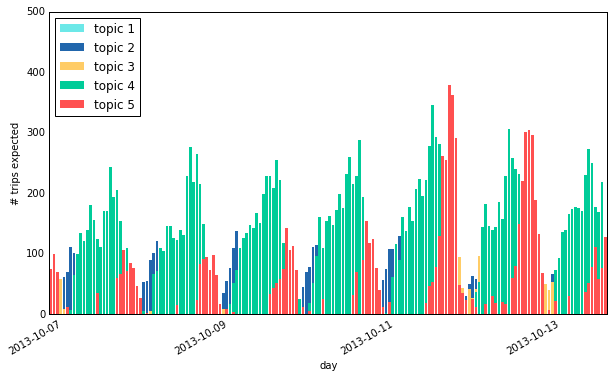

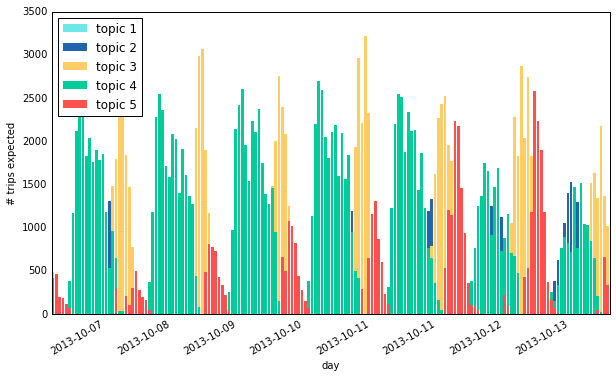

In [6]:
# plot number of trips by hour, with diff color for each topic to which that trip belongs. 
# df is the trips_hour dataframe we just constructed. xlims is the range of dates to plot. 
import matplotlib.ticker as plticker

def plot_trip_by_hour(df, xlims ):
    
    red, blue, cyan, orange, green = '#FF5050', '#2166AC','#6CE8E8', '#FFCC66', '#00CC99'
    fig = plt.figure(figsize=(10, 6))
    
    df = df.sort(columns = ['date','hour']).reset_index()
    
    ind = range(len(df))
    
    t1 = df.trips0
    t2 = df.trips1
    t3 = df.trips2
    t4 = df.trips3
    t5 = df.trips4

    ax = plt.subplot(111)

    ax.bar(ind, t1, color=cyan, label='topic 1', edgecolor = 'none')
    ax.bar(ind, t2, bottom = 0, color=blue, label='topic 2', edgecolor = 'none')
    ax.bar(ind, t3, bottom = 0, color=orange, label='topic 3', edgecolor = 'none')
    ax.bar(ind, t4, bottom = 0, color=green, label='topic 4', edgecolor = 'none')
    ax.bar(ind, t5, bottom = 0, color=red, label='topic 5', edgecolor = 'none')
    
    plt.ylabel("# trips expected")
    plt.xlabel("day")
    
    
    #xmarklabs = []
    ax.set_xlim(xlims)
    #loc = plticker.MultipleLocator(base=24) # this locator puts ticks at regular intervals
    #ax.xaxis.set_major_locator(loc)
    
    a=ax.get_xticks().tolist()
    labels = [df.date[lab] for lab in a]
    ax.set_xticklabels(labels)
    plt.tick_params(which='major', length=0)
    #xmarks = range(xlims[0],xlims[1], 24)
    #labels = [df.date[i] for i in xmarks]
    #plt.xticks(xmarks, labels, rotation='horizontal')
    #ax.set_ylim([0,1])
    
    ax.legend(loc='upper left')
    fig.autofmt_xdate()
    plt.show()

    
plot_trip_by_hour(sf_trips_hour, xlims=[3096, 3096+168])
plot_trip_by_hour(nyc_trips_hour,xlims=[144,144+168] )

[[ 0.65364984  0.          0.          0.13103599  0.21025993]
 [ 0.62669737  0.          0.          0.22035691  0.14635282]
 [ 0.52328232  0.02513653  0.          0.28726316  0.15961929]
 ..., 
 [ 0.2         0.2         0.2         0.2         0.2       ]
 [ 0.2         0.2         0.2         0.2         0.2       ]
 [ 0.2         0.2         0.2         0.2         0.2       ]]


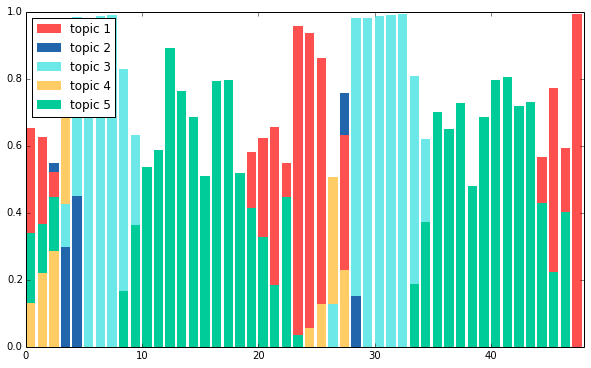

In [300]:
#plots topic probabilities by hour. 
def plot_topics_by_hour(topics, k):
    topic_by_hour = np.zeros((len(topics),k))
    for i, h in enumerate(topics):
        row = [0]*k
        for t in range(len(h)):
            topic = h[t][0]
            prob = h[t][1]
            row[topic] = prob
        topic_by_hour[i] = row
    print topic_by_hour

    
    red, blue, cyan, orange, green = '#FF5050', '#2166AC','#6CE8E8', '#FFCC66', '#00CC99'

    fig = plt.figure(figsize=(10, 6))
    ind = range(len(topics))
    t1 = topic_by_hour[:,0]
    t2 = topic_by_hour[:,1]
    t3 = topic_by_hour[:,2]
    t4 = topic_by_hour[:,3]
    t5 = topic_by_hour[:,4]

    ax = plt.subplot(111)
    ax.bar(ind, t1, color=red, label='topic 1', edgecolor = 'none')
    ax.bar(ind, t2, bottom = t1, color=blue, label='topic 2', edgecolor = 'none')
    ax.bar(ind, t3, bottom = t2, color=cyan, label='topic 3', edgecolor = 'none')
    ax.bar(ind, t4, bottom = t3,color=orange, label='topic 4', edgecolor = 'none')
    ax.bar(ind, t5, bottom = t4,color=green, label='topic 5', edgecolor = 'none')
    #plt.xticks([0.5, 1.5, 2.5], ['1st Class', '2nd Class', '3rd Class'], rotation='horizontal')
    #plt.ylabel("Number")
    #plt.xlabel("")
    ax.set_ylim([0,1])
    ax.set_xlim([0,48])
    ax.legend(loc='upper left')
    plt.show()
    
    
def get_topic_probs_by_hour(topics, k):
    topic_by_hour = np.zeros((len(topics),k))
    for i, h in enumerate(topics):
        row = [0]*k
        for t in range(len(h)):
            topic = h[t][0]
            prob = h[t][1]
            row[topic] = prob
        topic_by_hour[i] = row
    return topic_by_hour

    
plot_topics_by_hour(sf_topics, 5)
sf_top_probs = get_topic_probs_by_hour(sf_topics, 5)
#nyc_top_probs = get_topic_probs_by_hour(nyc_topics, 5)

In [257]:
# How did ODs change topic by hour?

# for each hour, find the most probable topic. 
def get_topics_by_hour(topics, k):
    tops_by_hour = np.zeros((len(topics),1))
    for i, h in enumerate(topics):
        prob_list = []
        topic_list = []
        for t in range(len(h)):
            topic = h[t][0]
            prob = h[t][1]
            prob_list.append(prob)
            topic_list.append(topic)
            top = topic_list[np.argmax(prob_list)]
        tops_by_hour[i] = top
    return tops_by_hour
    

sf_topics_by_hour = get_topics_by_hour(sf_topics, 5)
nyc_topics_by_hour = get_topics_by_hour(nyc_topics, 5)

print sf_topics_by_hour[:25]

[[ 0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 4.]
 [ 4.]
 [ 4.]
 [ 4.]
 [ 4.]
 [ 4.]
 [ 4.]
 [ 4.]
 [ 4.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
